#Best Model
This notebook is the one with the model that achieved the best results overall.
It uses a Unet architecture and some Image Data Augmetnation on the training set.
Training was done in two parts one with a higher learning rate and one with a lower lerning rate to increase accuracy.

IMPORTANT: this notebook is written to work on Colab mounted with Drive. 
To remove the dependacy from Drive delete cell where drive is mounted and remove My Drive/content from paths as specified commented lines of code.

The Development Dataset has to be located on drive (or in the same folder if running without drive) and contain the validation and training txt file splits.
Its structure is:

Development_Dataset: 
  > Images (contains all training images, so in our case only BipBip images)

  > Masks (contains all training masks, so in our case only BipBip images)

  > Splits (contains split txt files)

  > Test_Dev (contains all test images)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import tensorflow as tf
import numpy as np
import sys 
import time
import matplotlib.pyplot as plt
import pandas as pd
import json
import cv2

from os import listdir
from datetime import datetime
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input 




SEED = 1234
tf.random.set_seed(SEED)  
BS=1

In [ ]:
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Delete to execute out of drive 

Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/Development_Dataset.zip #remove '/content/drive/My\ Drive/' if executing out of drive

Archive:  /content/drive/My Drive/Development_Dataset.zip
   creating: Development_Dataset/
  inflating: Development_Dataset/.DS_Store  
  inflating: __MACOSX/Development_Dataset/._.DS_Store  
   creating: Development_Dataset/Images/
   creating: Development_Dataset/Test_Dev/
  inflating: __MACOSX/Development_Dataset/._Test_Dev  
   creating: Development_Dataset/Masks/
   creating: Development_Dataset/Splits/
  inflating: Development_Dataset/Images/Bipbip_haricot_im_07131.jpg  
  inflating: __MACOSX/Development_Dataset/Images/._Bipbip_haricot_im_07131.jpg  
  inflating: Development_Dataset/Images/Bipbip_haricot_im_06401.jpg  
  inflating: __MACOSX/Development_Dataset/Images/._Bipbip_haricot_im_06401.jpg  
  inflating: Development_Dataset/Images/Bipbip_mais_im_03511.jpg  
  inflating: __MACOSX/Development_Dataset/Images/._Bipbip_mais_im_03511.jpg  
  inflating: Development_Dataset/Images/Bipbip_haricot_im_03961.jpg  
  inflating: __MACOSX/Development_Dataset/Images/._Bipbip_haricot_im_0

## Functions

In [ ]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0 #254 instead of 216
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

## Training Dataset Class

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask_from_rgb = read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
    mask = Image.fromarray(mask_from_rgb)

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask_arr = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask_arr)
    

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

## Dataset Setup

In [ ]:
# Datagenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object

if apply_data_augmentation:
  img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
  
  mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')  
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

test_data_gen=ImageDataGenerator()    

In [ ]:
img_h = 1536
img_w = 2048

dataset = CustomDataset('/content/Development_Dataset/', 'training',  #remove '/content' if out of Drive
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        out_shape=(img_w,img_h)) ##### first height
dataset_valid = CustomDataset('/content/Development_Dataset/', 'validation', #remove '/content' if out of Drive
                              out_shape=(img_w,img_h)) 


In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(BS)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(BS)

valid_dataset = valid_dataset.repeat()


### Test Data Generators

In [ ]:
from matplotlib import cm

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

[0. 1. 2.]


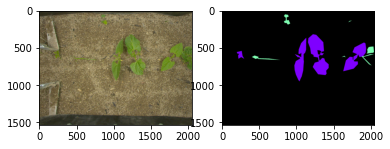

In [ ]:
# Let's test data generator
import time
import matplotlib.pyplot as plt

%matplotlib inline



iterator = iter(valid_dataset)

fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   
augmented_img = augmented_img  


target = np.array(target[0, ..., 0]) 

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Defineition of Unet Model

Model Unet

In [ ]:
from keras.models import *
from keras.layers import *

def unet(img_size, num_classes, pretrained_weights = None):  #default ,input_size = (256,256,1)
    
    #inputs = Input(input_size)
    inputs = keras.Input(shape=img_size + (3,))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs) #kernel_initializer = 'he_normal'
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same')(conv9) 

    conv10 = Conv2D(num_classes, 3, activation="softmax", padding="same")(conv9)

    model = keras.Model(inputs, conv10)
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

Create Model

In [ ]:
# Build model
img_size=(img_h,img_w)
num_classes=3
model = unet(img_size, num_classes) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1536, 2048,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1536, 2048, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1536, 2048, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 768, 1024, 32 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Model Parameters and Metrics setup

In [ ]:
# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 

# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Metric definition
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#Checkpoints & Early Stopping 

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments') #remove '/drive/My drive' if out of Drive
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Early Stopping
early_stop = False
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='meanIoU', patience=10,restore_best_weights = True )
    callbacks.append(es_callback)

## Model Fit

In [ ]:
model.fit(x=train_dataset,
          epochs=70,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)//BS,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/70
162/162 [==============================] - 440s 3s/step - loss: 0.7255 - accuracy: 0.7924 - meanIoU: 0.0970 - val_loss: 0.1426 - val_accuracy: 0.9649 - val_meanIoU: 0.3896
Epoch 2/70
162/162 [==============================] - 440s 3s/step - loss: 0.1293 - accuracy: 0.9505 - meanIoU: 0.3419 - val_loss: 0.1252 - val_accuracy: 0.9673 - val_meanIoU: 0.3957
Epoch 3/70
162/162 [==============================] - 441s 3s/step - loss: 0.1196 - accuracy: 0.9513 - meanIoU: 0.3453 - val_loss: 0.1117 - val_accuracy: 0.9705 - val_meanIoU: 0.4072
Epoch 4/70
162/162 [==============================] - 439s 3s/step - loss: 0.1156 - accuracy: 0.9518 - meanIoU: 0.3480 - val_loss: 0.1020 - val_accuracy: 0.9719 - val_meanIoU: 0.4118
Epoch 5/70
162/162 [==============================] - 435s 3s/step - loss: 0.1134 - accuracy: 0.9521 - meanIoU: 0.3497 - val_loss: 0.0985 - val_accuracy: 0.9723 - val_meanIoU: 0.4138
Epoch 6/70
162/162 [==============================] - 438s 3s/step - loss: 0.1117 - a

KeyboardInterrupt: ignored

In [ ]:
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.fit(x=train_dataset,
          epochs=20,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)//BS,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/20
162/162 [==============================] - 450s 3s/step - loss: 0.0351 - accuracy: 0.9861 - meanIoU: 0.7674 - val_loss: 0.0779 - val_accuracy: 0.9754 - val_meanIoU: 0.5673
Epoch 2/20
162/162 [==============================] - 443s 3s/step - loss: 0.0356 - accuracy: 0.9859 - meanIoU: 0.7631 - val_loss: 0.0783 - val_accuracy: 0.9752 - val_meanIoU: 0.5647
Epoch 3/20
162/162 [==============================] - 438s 3s/step - loss: 0.0352 - accuracy: 0.9861 - meanIoU: 0.7647 - val_loss: 0.0781 - val_accuracy: 0.9755 - val_meanIoU: 0.5687
Epoch 4/20
162/162 [==============================] - 438s 3s/step - loss: 0.0349 - accuracy: 0.9862 - meanIoU: 0.7668 - val_loss: 0.0792 - val_accuracy: 0.9753 - val_meanIoU: 0.5664
Epoch 5/20
162/162 [==============================] - 437s 3s/step - loss: 0.0346 - accuracy: 0.9863 - meanIoU: 0.7685 - val_loss: 0.0778 - val_accuracy: 0.9757 - val_meanIoU: 0.5715
Epoch 6/20
162/162 [==============================] - 434s 3s/step - loss: 0.0342 - a

## Prediction

In [ ]:
submission_dict = {}
test_dir='/content/Development_Dataset/Test_Dev' #remove '/content' if executing out of drive
teams= ['Bipbip','Pead','Roseau','Weedelec']
plants=['Haricot','Mais']

for team in teams:
  if (team == 'Bipbip'):
    shape = (2048,1536) #(W,H)
  if (team == 'Pead'):
    shape = (3280,2464)
  if (team == 'Roseau'):
    shape = (1227,819)
  if (team == 'Weedelec'):
    shape = (5184,3456)
  for plant in plants:
    path=test_dir+'/'+team+'/'+plant+'/Images'
    for image in os.listdir(path):
      img = Image.open(os.path.join(path, image))
      imgsize=img.size
      print(imgsize)

      img=np.array(img)
      
      if (team =='Bipbip'):
        out_sigmoid = model.predict(x=tf.expand_dims(img, 0))
        predicted_class = tf.argmax(out_sigmoid, -1)
        predicted_class = predicted_class[0, ...]
        predicted_class=np.asarray(predicted_class)
      else :
        predicted_class = np.zeros([imgsize[0], imgsize[1], 3])
        predicted_class = np.asarray(predicted_class)
      
      if (team == 'Roseau'):
        img_name = image.replace('.png', '')
      else:
        img_name = image.replace('.jpg', '')
      print(img_name) 

      
      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = predicted_class.shape
      submission_dict[img_name]['team'] = team
      submission_dict[img_name]['crop'] = plant
      submission_dict[img_name]['segmentation'] = {}

      rle_encoded_crop = rle_encode(predicted_class == 1)
      
      rle_encoded_weed = rle_encode(predicted_class == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed


Creation of Submission Json

In [ ]:
exps_dir = os.path.join(cwd, 'drive/My Drive/predictions') #remove 'drive/My Drive/' if executing out of drive
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)


dir=exps_dir+'/submission'+'_'+datetime.now().strftime('%b%d_%H-%M-%S')+'.json'
with open(dir, 'w') as f:
  json.dump(submission_dict, f)